# Building a CNN classifier on CIFAR10 with PyTorch

Welcome! This is my very first brush with PyTorch. I was reading through the PyTorch tutorials and I felt that they skipped over a lot of the explanations. That isn't really helpful for beginners. So I thought it would be good to do an __extremely documented__ version of the PyTorch tutorial. There are only minor changes to the code. I had so much fun and learnt so much just by doing this. Hope you will have fun too! :D

Alright, first up. We need to import torch and torchvision. Torchvision is used when you want to load datasets such as MNIST, CIFAR10, etc. We also should import torchvision.transforms - this is a package that we can use to easily apply image transformations such as changing to a tensor, and normalizing, etc.

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms

We want to define a transform variable here because later on when we load the CIFAR10 dataset, we can simply specify the _transform_ parameter as transform. The transforms (note the 's') class has a method called Compose([trans1, trans2, trans3...]), which helps to chain image transformations together. 

The Normalize transformation takes two arguments: (mean, stdev). Here, mean is a tuple representing the mean values for each channel (R, G, B). It has a value of 0.5 because later on when we load CIFAR10 datasets via DataLoader, the output are PIL images of range(0,1). The same goes for stdev.

In [3]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

As mentioned, we first directly get the data frrom torchvision's datasets, and we apply the transform that we defined earlier. We then create a DataLoader, which will help to subsample, shuffle, to return a batch with size = batch_size. We do the same for the test set as well.

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# To load the CIFAR10 test set, we simply need to set train = False
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's check the size of the training and test set.

In [139]:
print("# of images in training set =", len(trainset))
print("# of images in test set =", len(testset))

# of images in training set = 50000
# of images in test set = 10000


Now we want to see some of the images just for fun. First, let's see what we get from the trainloader.

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
#print(images, labels)
print(labels)

tensor([2, 6, 6, 2])


As you can see, trainloader actually returns the labels of the images in numbers. Hence, that is why we defined the classes object above - we can simply get the label of the class by indexing classes i.e. classes[labels]. If you un-comment the other print line, you will get 4 huge tensors corresponding to the 4 images loaded via the trainloader.

Now that we've seen what trainloader returns, we can move on to actually plotting the images. But first, let's take a look at what this function torchvision.utils.make_grid actually returns.

In [52]:
print(torchvision.utils.make_grid(images))

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.1608,  ..., -0.1294,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000, -0.0510,  ...,  0.6157,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.2392,  ..., -0.0824,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000, -0.1608,  ...,  0.5922,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

As you can see, what make_grid actually does is pretty interesting. It pads the tensor images with zeros so that it creates 'space' around each image when you want to plot them. This creates a "grid" without having to use subplotting in Matplotlib

Alright. Now, we can finally move on to plotting of the images. However, there are 3 things to take note. Firstly, since Matplotlib works with Numpy arrays rather than PyTorch tensors, we will need to convert them. PyTorch makes this simple just by tensor.numpy(). Secondly, we need to un-normalize the tensors so that we get back the original image. Thirdly, the format in PyTorch is (channels, width, height), but in Matplotlib it is (width, height, channel). Hence, we will need to some transposing to re-order the axes.

Let's define our own imshow function to plot the images returned to us via the make_grid function by doing all the necessary conversion steps before running Matplotlib's imshow command.

     bird        frog        frog        bird   


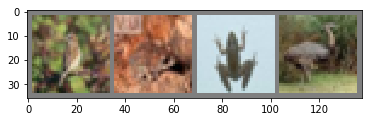

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(image):
    image = image / 2 + 0.5
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1,2,0)))
    
imshow(torchvision.utils.make_grid(images))
class_labels = ""
for j in range(4):
    class_labels += "     " + classes[labels[j]] + "   "
    
print(class_labels)

Alright! We've done our data loading, pre-processsing, and visualisation, now it's time to move on to actually building the model. We will be using a Convolutional Neural Network (obviously).

We will need to import torch.nn and torch.nn.functional. torch.nn is the package that has a class called Module. Modules is the super class for all neural network objects you create. So you should make your neural network object be a subclass of Module. torch.nn.functional is only imported because we want to use relu.

So the logic of what we are going to do is to define a Net class (which is a subclass of Module), which will have an init method to define the layers in the neural network, and a forward method which describes one forward pass of a tensor through the neural network. It is in the forward method where the architecture of the NN is described.

In [140]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1)
        self.fc1 = nn.Linear(in_features=16*5*5,out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features = 84, out_features=10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = CNN()

So you might probably be thinking, what the hell is that super()... line doing? Well, in this case super() is a method defined in the standard Python library which helps you to access inherited parent methods which have been over-ridden by child methods. So, because we want to make use of the init method in nn.Module, but we also need to define our own init method in the child. Therefore, we use super() so that we can call the init parent method anyway. We need to call the init parent method because in the init parent method there are many things to initialize such as self.training = True, self.backend = thnn_backend, blah blah blah. So we don't need to write all that down by using super. If you're still confused about super, you can refer to the first example in this link, it's pretty clear: https://www.programiz.com/python-programming/methods/built-in/super

CIFAR10 images are 32 x 32 x 3. The nasty thing about using PyTorch or Tensorflow or any other of the DL frameworks besides Keras is that we have to keep track of the size of the tensors as they flow though the neural network. Below is a function that allows us to see the output size after each layer. As you can see, the 5x5x16 output size at the end correlates with the argument passed into x.view. x.view is just meant to flatten the tensor so it can be passed to the fc layers.

In [141]:
def tensor_size_calculator(input_width, kernel_size, padding, stride):
    output_width = int((input_width - kernel_size + 2 * padding)/stride) + 1
    return output_width

print("Conv1 output size = {} x {} x {}".format(tensor_size_calculator(32,5,0,1), tensor_size_calculator(32,5,0,1), 6))
print("Pool output size = {} x {} x {}".format(tensor_size_calculator(28,2,0,2), tensor_size_calculator(28,2,0,2), 6))
print("Conv2 output size = {} x {} x {}".format(tensor_size_calculator(14,5,0,1), tensor_size_calculator(14,5,0,1), 16))
print("Pool output size = {} x {} x {}".format(tensor_size_calculator(10,2,0,2), tensor_size_calculator(10,2,0,2), 16))

Conv1 output size = 28 x 28 x 6
Pool output size = 14 x 14 x 6
Conv2 output size = 10 x 10 x 16
Pool output size = 5 x 5 x 16


Great! So now that we have created our model instance, we can begin training the model. But first we want to train on GPU rather than CPU, so we create a device and pass "cuda:0" as the argument. This means we want to use the GPU with ID 0. We could have just as well passed "cuda" as the argument, and the default GPU would have been used.

In PyTorch, if we want to use GPU, we need to ensure that we move all tensors, and models on to the GPU. That's why we use net.to(device). By right, these two lines of code should be written in the CNN class.

In [142]:
device = torch.device("cuda:0")
net.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Next up we simply define our optimizer so it can be re-used easily later on. Note that this step must be done after we have moved the NN to cuda, because parameters before and after moving to cuda are different. Note that this step does _more than_ just initialize the optimizer - it also passes the parameters of the neural network to the optimizer so that it gets updated. In other words, you must always run this cell before you do any training, otherwise __the NN's parameters will not be updated__.

In [143]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Alright, let's train the model! In the train model_function, we need to do the following steps: load the images from the dataloader, pass the images through the neural network to get the output, find the categorical crossentropy loss wrt the ground truth labels, differentiate loss wrt weights, update the weights, and then zero out the gradients. The code below is documented with comments to tell where each line is doing each part. You might be wondering why we need to zero out the gradients - this is simply because of a quirk in PyTorch where they accummulate the gradients after every iteration (doing so is helpful in training RNNs). That's not what we want - we want only the gradient for that iteration to update the weights.

Similarly for the running loss, we also need to zero it out after every mini-batch is completed, otherwise we would be reporting the accummulated running loss rather than the (average) loss for that mini-batch. Oh and, we update running_loss by adding itself to loss.item(). This .item() is a numpy method which simply just returns a scalar value from an ndarray.

Note that for each iteration, because we defined the batch size to be 4 in the data loader, _images_ is actually a tensor made up of 4 images.

In [144]:
def train_model(num_epochs, batch_size):    
    for j, epoch in enumerate(range(num_epochs), 1):
        print ("Epoch {} ----------------------------->".format(j)) # just some fancy aesthetics
        running_loss = 0.0 # when you start a new epoch, reset running_loss
        for i, data in enumerate(trainloader, 1):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # Pass images through one forward pass of the neural network
            outputs = net(images)
            # zero out the gradients since it accummulates
            optimizer.zero_grad()
            # Calculate the cross entropy loss of outputs
            loss = nn.CrossEntropyLoss()(outputs, labels)
            # Differentiate loss wrt weights
            loss.backward()
            # update the weights i.e. weights -= learning rate * gradients
            optimizer.step()
            # Print some statistics
            running_loss += loss.item()
            if i % BATCH_SIZE == 0:
                print ("Batch {} | Loss = {:.3f}".format(i//batch_size, running_loss/batch_size))
                running_loss = 0.0

    return "Finished Training"

In [145]:
NUM_EPOCHS = 5 
BATCH_SIZE = 2500
train_model(NUM_EPOCHS, BATCH_SIZE)

Epoch 1 ----------------------------->
Batch 1 | Loss = 2.198
Batch 2 | Loss = 1.795
Batch 3 | Loss = 1.599
Batch 4 | Loss = 1.538
Batch 5 | Loss = 1.465
Epoch 2 ----------------------------->
Batch 1 | Loss = 1.400
Batch 2 | Loss = 1.337
Batch 3 | Loss = 1.319
Batch 4 | Loss = 1.289
Batch 5 | Loss = 1.270
Epoch 3 ----------------------------->
Batch 1 | Loss = 1.206
Batch 2 | Loss = 1.200
Batch 3 | Loss = 1.182
Batch 4 | Loss = 1.160
Batch 5 | Loss = 1.158
Epoch 4 ----------------------------->
Batch 1 | Loss = 1.077
Batch 2 | Loss = 1.104
Batch 3 | Loss = 1.100
Batch 4 | Loss = 1.099
Batch 5 | Loss = 1.075
Epoch 5 ----------------------------->
Batch 1 | Loss = 1.004
Batch 2 | Loss = 1.021
Batch 3 | Loss = 1.022
Batch 4 | Loss = 1.029
Batch 5 | Loss = 1.026


'Finished Training'

It shouldn't be surprising that we get 5 batches per epoch. After all, our training set is 50,000 images, and we specified that each set of images that gets loaded by the DataLoader at each iteration will be in sets of 4. There are 12,500 sets of 4 images in our training set, and with a batch size of 2,500 we divide the 12,500 sets exactly by 5.

In [130]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = net(images.to(device))
print(outputs.size())

torch.Size([4, 10])


So the output is as we expect. Each image passed into the model is output as a 10-length vector, with each element representing the probability for each class. 

Take a look at the cell below. When we pass outputs into torch.max(), it automatically returns two tensors, the first tensor are the actual max probability values, while the second tensor are the class labels. Later on when we want to see the predictions made my the model, we can simply use the second tensor to index _classes_

In [131]:
print(torch.max(outputs, dim=1))

(tensor([1.7345, 9.6868, 3.4898, 4.5370], device='cuda:0', grad_fn=<MaxBackward0>), tensor([3, 8, 8, 8], device='cuda:0'))


     cat        ship        ship        ship   


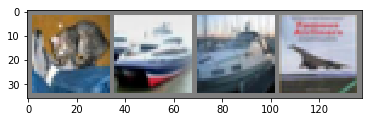

In [132]:
_, prediction = torch.max(outputs,dim=1)
predictions = ""
for p in range(4):
    predictions += "     " + classes[prediction[p]] + "   "
print(predictions)
imshow(torchvision.utils.make_grid(images))

Not bad! It was able to correctly identify the cat and the ships, but it didn't identify the plane correctly.

Alright, now let's evaluate the model. The next few lines of code should be reasonably easy to understand. Just a few things - when evaluating a model, we don't need to use up memory to keep track of the gradients, hence we use with torch.no_grad() to achieve this.

Secondly, don't be confused about outputs.data in line 8 - the only difference between outputs and outputs.data is that outputs.data doesn't store the function that was used to create it (refer below). Using outputs in this case would have worked as well, albeit a little slower (or perhaps with more memory used). 

In [136]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 4 + 4 + 4 + ....
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on 10,000 test images: %d %%' %(correct*100/total))

Accuracy of the network on 10,000 test images: 61 %


In [135]:
print(outputs.data)
print(outputs)

tensor([[-0.3151, -1.0076,  0.4473,  1.7345, -1.5261,  0.1395,  1.0854, -2.7348,
          1.6600, -0.9724],
        [ 5.6639,  6.8265, -2.7914, -3.2155, -3.0998, -6.8968, -3.3692, -6.0523,
          9.6868,  3.4894],
        [ 2.3984,  2.1962, -0.9199, -1.8278, -1.3179, -3.5441, -2.7176, -2.6169,
          3.4898,  2.7895],
        [ 4.3817,  1.2596, -0.2201, -2.4330, -0.8555, -3.8689, -2.5782, -3.0362,
          4.5370,  0.7805]], device='cuda:0')
tensor([[-0.3151, -1.0076,  0.4473,  1.7345, -1.5261,  0.1395,  1.0854, -2.7348,
          1.6600, -0.9724],
        [ 5.6639,  6.8265, -2.7914, -3.2155, -3.0998, -6.8968, -3.3692, -6.0523,
          9.6868,  3.4894],
        [ 2.3984,  2.1962, -0.9199, -1.8278, -1.3179, -3.5441, -2.7176, -2.6169,
          3.4898,  2.7895],
        [ 4.3817,  1.2596, -0.2201, -2.4330, -0.8555, -3.8689, -2.5782, -3.0362,
          4.5370,  0.7805]], device='cuda:0', grad_fn=<ThAddmmBackward>)


Alright!! There we go. We've just trained our first model in PyTorch. It's accuracy isn't that high, but remember that we've only trained it over 5 epochs and we haven't done much pre-processing and hyperparameter tuning. 

Anyway, Congratulations!!